# Climate XGBoost Prediction

##### Using XGBRegressor from the XGBoost library, we will make a regression model to forecast the temperature for the test data.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
from IPython.display import Image


from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

### Data Understanding

##### First we will read in the data and look at our given data as well as visualize it.

In [18]:
train_df = pd.read_csv("DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("DailyDelhiClimateTest.csv")

In [19]:
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [20]:
train_df.isnull().sum() # Look for missing values

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [22]:
train_df['date'] = pd.to_datetime(train_df['date']) # Change date to a datetime dtype
train_df = train_df.set_index('date')

# Make similar changes to the test data frame
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.set_index('date')

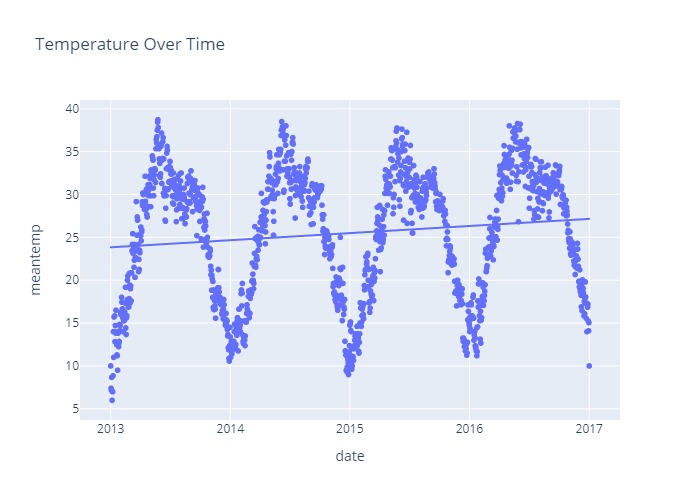

In [23]:
fig = px.scatter(train_df, x = train_df.index, y = "meantemp", trendline = "ols", title = "Temperature Over Time")
fig.write_image("graphs/temp.jpg")
Image("graphs/temp.jpg")

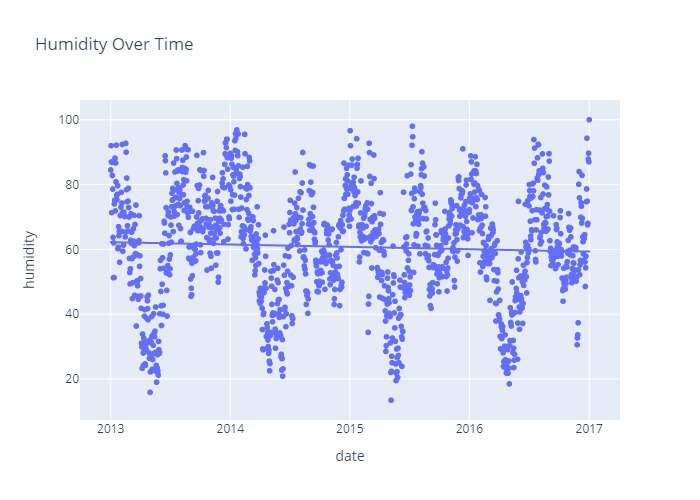

In [24]:
fig = px.scatter(train_df, x = train_df.index, y = "humidity", trendline = "ols", title = "Humidity Over Time")
fig.write_image("graphs/humidity.jpg")
Image("graphs/humidity.jpg")

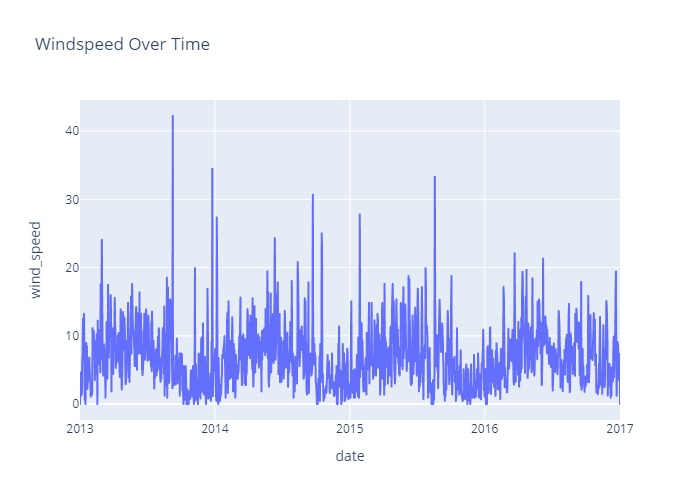

In [25]:
fig = px.line(train_df, x = train_df.index, y = "wind_speed", title = "Windspeed Over Time")
fig.write_image("graphs/windspeed.jpg")
Image("graphs/windspeed.jpg")

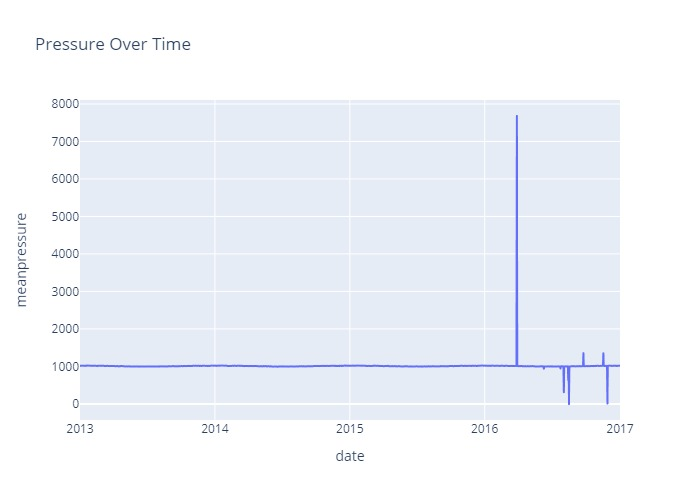

In [26]:
fig = px.line(train_df, x = train_df.index, y = "meanpressure", title = "Pressure Over Time")
fig.write_image("graphs/pressure.jpg")
Image("graphs/pressure.jpg")

##### In the meantemp column, we have a couple of eyepopping outliers that are adding a larger range to the data than needed.
##### Therefore, we will remove the outliers in the column and regraph the data for meantemp.

In [27]:
before = len(train_df)
q3, q1 = np.percentile(train_df['meanpressure'], [75 ,25])
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)
train_df = train_df.loc[(train_df['meanpressure'] > lower) & (train_df['meanpressure'] < upper)]

print(before - len(train_df), "rows were dropped.")

9 rows were dropped.


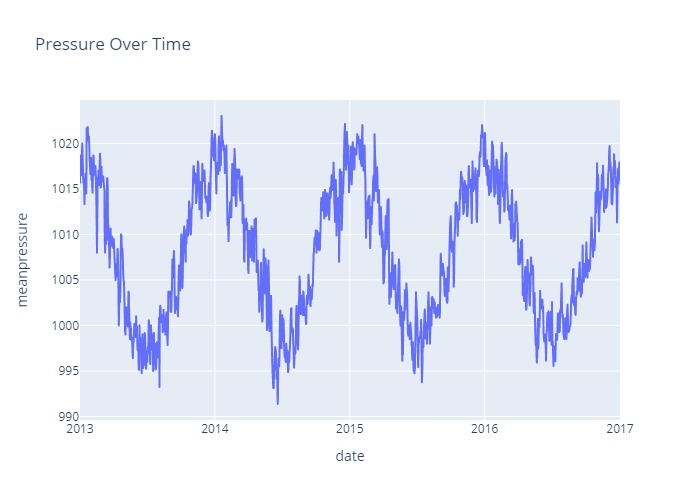

In [28]:
# Now, re-graph new cleaned data.
fig = px.line(train_df, x = train_df.index, y = "meanpressure", title = "Pressure Over Time")
fig.write_image("graphs/cleaned_pressure.jpg")
Image("graphs/cleaned_pressure.jpg")

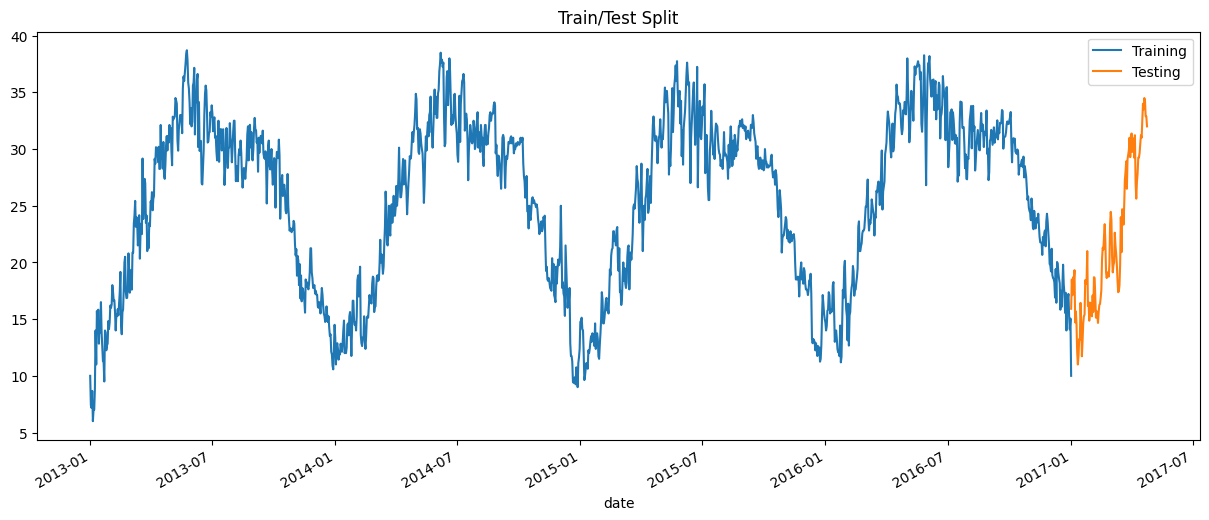

In [29]:
fig, ax = plt.subplots(figsize = (15,6))
train_df.plot(ax = ax, y = "meantemp", label = "Training", title = "Train/Test Split")
test_df.plot(ax = ax, y = "meantemp", label = "Testing")
plt.show()

In [30]:
train_df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr()

,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.575328,0.307407,-0.878969
humidity,-0.575328,1.000000,-0.374039,0.332819
wind_speed,0.307407,-0.374039,1.000000,-0.294541
meanpressure,-0.878969,0.332819,-0.294541,1.000000


In [31]:
train_df['day'] = train_df.index.day
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year

test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['year'] = test_df.index.year

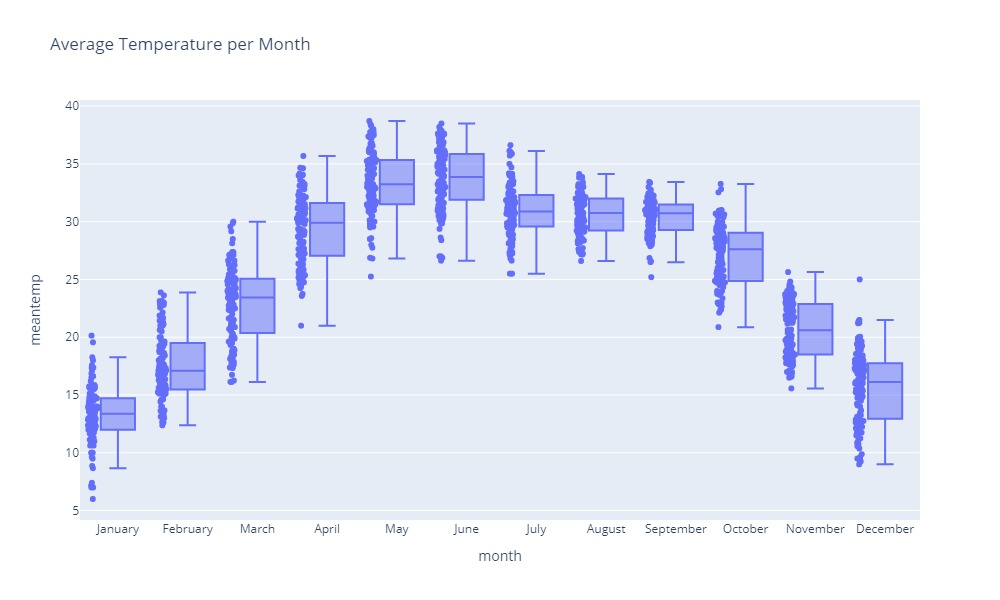

In [32]:
fig = go.Figure(px.box(train_df, x = "month", y = "meantemp", points = "all", title = "Average Temperature per Month", width = 1000, height = 600))
fig.update_layout(xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(1,13)),
        ticktext = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)
)

fig.write_image("graphs/avg_temp.jpg")
Image("graphs/avg_temp.jpg")

### Data Modeling

In [33]:
features = ['humidity', 'wind_speed', 'meanpressure', 'day', 'month', 'year']
target = 'meantemp'

X_train = train_df[features]
X_test = test_df[features]

y_train = train_df[target]
y_test = test_df[target]

In [34]:
reg = xgb.XGBRegressor(n_estimators = 1000)
reg.fit(X_train, y_train, verbose = 10)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
score = reg.score(X_train, y_train) 
print("The score of our Model was:", score)

The score of our Model was: 0.9999998981982146


### Forecasting Testing Data

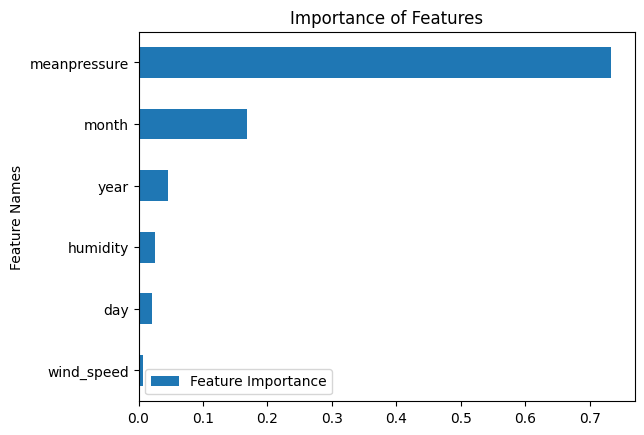

In [36]:
# Feature Importance
importance = pd.DataFrame({'Feature Names' : [x for x in reg.feature_names_in_],
              'Feature Importance' : [x for x in reg.feature_importances_]})
importance = importance.set_index('Feature Names')

importance = importance.sort_values('Feature Importance')
importance.plot(kind = "barh", title = "Importance of Features")
plt.show()

In [37]:
test_df['predtemp'] = reg.predict(X_test)
    
# Metrics
mae = mean_absolute_error(test_df['meantemp'], test_df['predtemp'])
mse = mean_squared_error(test_df['meantemp'], test_df['predtemp'])
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 2.643075717819699
Mean Squared Error: 10.944651628337002
Root Mean Squared Error: 3.308270186719489


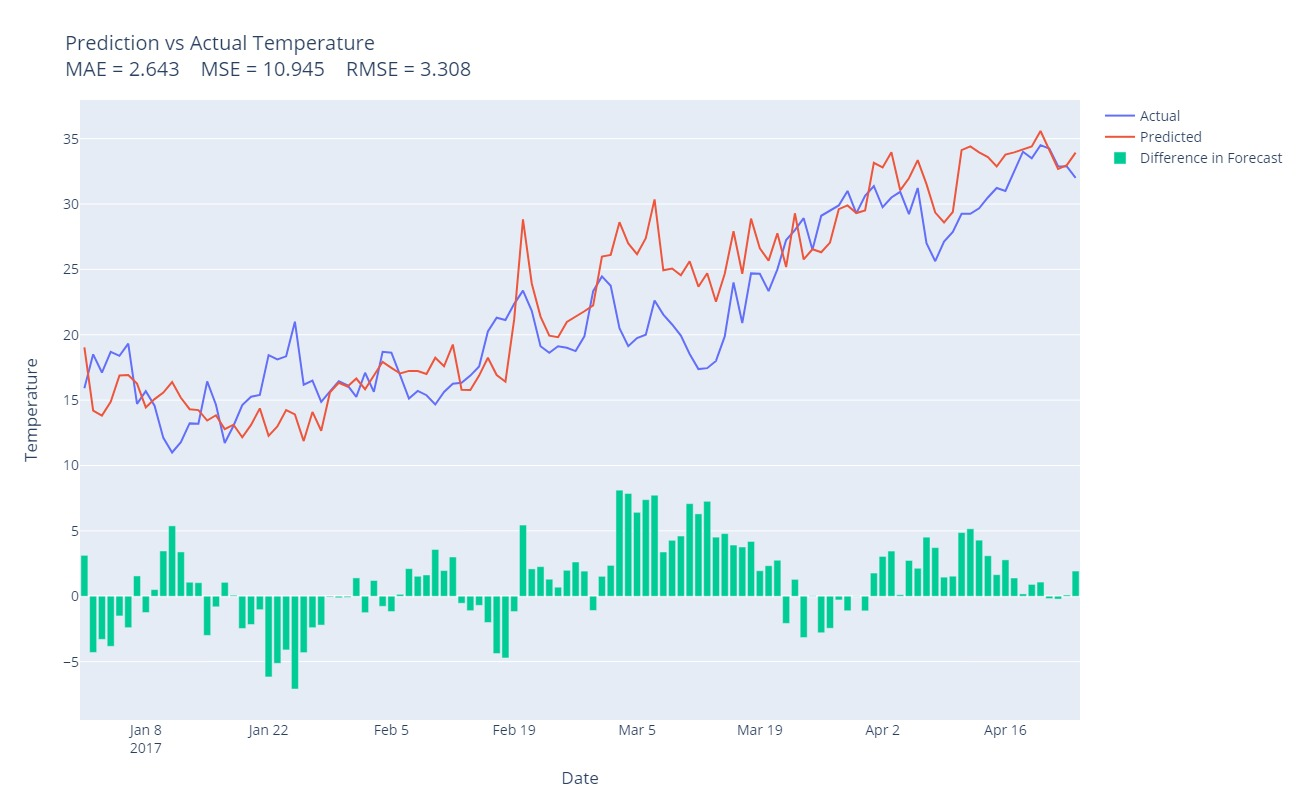

In [38]:
title = f'Prediction vs Actual Temperature <br>MAE = {mae:.3f}    MSE = {mse:.3f}    RMSE = {rmse:.3f}'
fig = go.Figure()
fig.add_trace(go.Scatter(x = test_df.index, y = test_df['meantemp'], 
                         mode = "lines", name = "Actual"))
fig.add_trace(go.Scatter(x = test_df.index, y = test_df['predtemp'], 
                         mode = "lines", name = "Predicted"))
fig.add_trace(go.Bar(x = test_df.index, y = test_df['predtemp'] - test_df['meantemp'], 
                    name = "Difference in Forecast"))

fig.update_layout(width = 1300, height = 800, title_text = title, 
                  xaxis_title = "Date", yaxis_title = "Temperature", font = dict(size = 14))
fig.write_image("graphs/pred_actual.jpg")
Image("graphs/pred_actual.jpg")